<a href="https://colab.research.google.com/github/halmichchristina/Colab/blob/master/Finished_WGAIN_SPAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAIN_SPAM GPU

#Methods

## Needed Packages

In [1]:
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
#Time
import time
#GPU
!pip install --upgrade pycuda
import pycuda.driver as cuda 
import pycuda.autoinit # Necessary for using its functions
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda.init()
#ROC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split




from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy import interp


     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 471kB 19.0MB/s 
  Created wheel for pycuda: filename=pycuda-2019.1.2-cp36-cp36m-linux_x86_64.whl size=4535569 sha256=bbf93ebbafa6da611cd727acc461391438859c1c76245187b56171fc0119f794
  Stored in directory: /root/.cache/pip/wheels/a6/60/f0/b1c430c73d281ac3e46070480db50f7907364eb6f6d3188396
  Created wheel for pytools: filename=pytools-2020.1-py2.py3-none-any.whl size=59604 sha256=d11c7ca1810a974282bda7565a7fca465818666ee04127ac8f280e71513e261d
  Stored in directory: /root/.cache/pip/wheels/6f/da/1b/946775a88291378182ed92c9800d6d0ebc2a554cb89829cc24
  Created wheel for mako: filename=Mako-1.1.1-cp36-none-any.whl size=75410 sha256=1c25c2b39dfa7add24832d25b0489124fbb0674a3a70d78c720e1c21fdf644df
  Stored in directory: /root/.cache/pip/wheels/ff/50/a9/0ddeed8679a1fb65bf4677cb9c92701828b2c1821e22ef72fd
Successfully built pycuda pytools mako


## Generator and Discriminator

In [0]:
class Generator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = torch.nn.Linear(input_size, hidden_size)
        self.map2 = torch.nn.Linear(hidden_size, hidden_size)
        self.map3 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x_in, m, z): #hier als x bereits bearbeitete
        inp =(1-m)*z# noise for missing values 
        input_x = torch.cat((x_in,m,inp),dim = 1)
        x = torch.tanh(self.map1(input_x))
        x = torch.tanh(self.map2(x))
        x = torch.sigmoid(self.map3(x))
        return x    

class Discriminator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = torch.nn.Linear(input_size, hidden_size)
        self.map2 = torch.nn.Linear(hidden_size, hidden_size)
        self.map3 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x_h, h):
        input_x = torch.cat((x_h,h),dim = 1)
        x = torch.tanh(self.map1(input_x.cuda()))
        x = torch.tanh(self.map2(x))     
        x = self.map3(x)
        return x 

## Sampling of M, Z , H

In [0]:
# Mask Vector
def sample_M(samples, n, p):
    A = torch.from_numpy(np.random.uniform(0., 1., size = [samples, n])).double()
    B = A > p
    C = 1.*B  
    return C.to(device)
# Random sample generator for Z
def sample_Z(samples, n):
    return torch.from_numpy(np.random.uniform(0., 1., size = [samples, n])).double()

# Hint for fake values -> Set 0.5 for one 0
def get_fake_H(M):
    H_fake = M.clone()
    samples, n = H_fake.shape
    m_index = torch.arange(samples, dtype=torch.long)
    n_index = m_index.clone()    
    for mi in m_index:  
        pos = (M[mi] == 0).nonzero()
        if(len(pos)!=0):
          n_i= torch.from_numpy(np.asanyarray(np.random.choice(pos[:,0])))
          n_index[mi] = n_i
          H_fake[mi, n_i] = 0.5       
    indices = zip(m_index, n_index)
    return H_fake.to(device), indices
  
# Hint for real values -> Set 0.5 for one 1
def get_real_H(M):
    H_fake = M.clone()
    samples, n = H_fake.shape
    m_index = torch.arange(samples, dtype=torch.long)
    n_index = m_index.clone()    
    for mi in m_index:  
        pos = (M[mi] == 1).nonzero()
        if(len(pos)!=0):
          n_i= torch.from_numpy(np.asanyarray(np.random.choice(pos[:,0])))
          n_index[mi] = n_i
          H_fake[mi, n_i] = 0.5       
    indices = zip(m_index, n_index)
    return H_fake.to(device), indices

## Loss, Show, GP Function

In [0]:
def calc_gradient_penalty(D, x_real, x_s,h, batch, LAMBDA):
  a = torch.rand(batch, 1)
  a = a.expand(x_real.size())
  a = a.to(device)
  interpolates = a * x_real + ((1 - a) * x_s)
  interpolates = interpolates.to(device)
  interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
  out = D(interpolates,h)
  gradients = torch.autograd.grad(outputs=out, inputs=interpolates,
                            grad_outputs=torch.ones(out.size()).to(device),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]

  gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
  return gradient_penalty
  
def calc_mse(x_s, x_in, m):
  norm_val = torch.sum(m)
  mse = torch.nn.functional.mse_loss(x_s, x_in, reduction="none")
  mse = mse * m
  mse = torch.sum(mse) / norm_val
  return mse

def calc_loss_observed(x_s, x_in, m, name_set):
  loss = 0
  if(name_set == 'CREDIT'):
    col_binary = [1,2,3,5,6,7,8,9,10]
    col = [0,4,11,12,13,14,15,16,17,18,19,20,21,22,23]
    lossfunc = torch.nn.CrossEntropyLoss()
    for i in col_binary:
      print('x_s', x_s[:,i])
      print('X_in',x_in[:,i])
      loss += lossfunc(x_s[:,i].float(), x_in[:,i].long())
      print('Loss calculated')
    for i in col:
      loss += torch.nn.functional.mse_loss(x_s[:,i], x_in[:,i], reduction="none")
    loss = loss * m
    loss = torch.sum(loss) / norm_val
    return loss
  else:
    loss = calc_mse(x_s, x_in, m)
  return loss

def calc_rmse(x_s, x, m):
  norm_val = torch.sum((1-m))
  rmse = torch.nn.functional.mse_loss(x_s, x, reduction="none")
  rmse = rmse * (1-m)
  rmse = torch.sqrt(rmse)
  rmse = torch.sum(rmse) / norm_val
  return rmse




## Plot

In [0]:
def plot(plot_rmse, plot_G, plot_D, plot_G_W, plot_GP, plot_D_P, name_set):
  rmse =[]
  for i in range(len(plot_rmse)):
    rmse.append(plot_rmse[i].cpu().numpy())
  rmse = np.asarray(rmse)

  g_loss=[]
  for i in range(len(plot_G)):
    g_loss.append(plot_G[i].cpu().numpy())
  g_loss = np.asarray(g_loss)

  d_loss=[]
  for i in range(len(plot_D)):
    d_loss.append(plot_D[i].cpu().numpy())
  d_loss = np.asarray(d_loss)


  G_W_loss=[]
  for i in range(len(plot_G_W)):
    G_W_loss.append(plot_G_W[i].cpu().numpy())
  G_W_loss = np.asarray(G_W_loss)


  GP_loss=[]
  for i in range(len(plot_GP)):
    GP_loss.append(plot_GP[i].cpu().numpy())
  GP_loss = np.asarray(GP_loss)

  DP_loss=[]
  for i in range(len(plot_D_P)):
    DP_loss.append(plot_D_P[i].cpu().numpy())
  DP_loss = np.asarray(DP_loss)




  rmse_n = (rmse-min(rmse))/(max(rmse)-min(rmse))
  g_loss_n = (g_loss-min(g_loss))/(max(g_loss)-min(g_loss))
  d_loss_n =(d_loss-min(d_loss))/(max(d_loss)-min(d_loss))
  gw_n = (G_W_loss-min(G_W_loss))/(max(G_W_loss)-min(G_W_loss))
  gp_n = (GP_loss-min(GP_loss))/(max(GP_loss)-min(GP_loss))
  dp_n = (DP_loss-min(DP_loss))/(max(DP_loss)-min(DP_loss))



  fig, ax = plt.subplots(figsize=(10,5))
  ax.plot(g_loss_n, 'r', label='G loss')
  ax.plot(d_loss_n, 'b', label='D loss')
  ax.plot(rmse_n, 'g', label='RMSE')
  #ax.plot(gw_n, 'c', label='WassersteinII')
  ax.plot(gp_n, 'm', label='Gradient Penalty')
  ax.plot(dp_n, 'k', label='Wasserstein I')
  legend = ax.legend(loc='upper right',  fontsize='x-large')
  plt.title(name_set)
  plt.show()

## Mean RMSE and STD

In [0]:
def print_statistics(test_loader,n,G, batch, p_miss):
  error = []
  for i in range(10):
      x,m,z = prepare_data(test_loader,p_miss, n, batch)
      x_in = x_in = m*x
      x_s = G(x_in, m, z)
      LM = calc_rmse(x_s,x_in,m)
      error.append(LM.detach())
  res = torch.mean(torch.stack(error))
  print("RMSE",res)

  std = torch.std(torch.stack(error))
  print("STD",std)


## WGAIN

In [0]:
def Wgain(G,D, data_loader,n, d_optimizer, g_optimizer, num_epochs, p_miss, batch, d_learning_rate, g_learning_rate, alpha, LAMBDA, name_set):
  start_complete = time.time()
  plot_rmse,plot_G,plot_D, plot_GP, plot_G_W, plot_D_P = [],[],[],[],[],[]
  for epoch in range(num_epochs): #or while train_loss not converged do:  
      #1.Train D with    
      D.zero_grad()
      G.zero_grad()
 #     for i in range(5):
      #Get Data
      x,m,z = prepare_data(data_loader,p_miss, n, batch)
      x_in = m*x
      #Run Generator
      x_s = G(x_in.to(device), m, z)
      x_h = m*x_in+(1-m)*x_s      
      #Get H for fake and real
      h_real, indices_real = get_real_H(m.cpu())
      h_fake, indices_fake = get_fake_H(m.cpu())        
      #Train Only Discriminator
      m_h_real = D(x_h.to(device),h_real.to(device))
      m_h_fake = D(x_h.to(device),h_fake.to(device))         
      #Calculate Gradient Penalty
      gradient_penalty = calc_gradient_penalty(D, x, x_s,h_fake, batch, LAMBDA) #h_real oder h_fake? 
      D.zero_grad()     
      # E_real so groß wie möglich E_fake so klein wie möglich
      dloss = torch.mean(m_h_fake)-torch.mean(m_h_real) 
      D_loss = torch.mean(m_h_fake)-torch.mean(m_h_real) + gradient_penalty  
      D_loss.backward() 
      d_optimizer.step()  
      #Unabhängig
          
    #2.Train G on D's response (but DO NOT train D on these labels)
      G.zero_grad()
      D.zero_grad()
     
      #Get Data
      x,m,z = prepare_data(data_loader,p_miss, n, batch)
      x_in = m*x
      
      #Run Generator
      x_s = G(x_in.to(device), m, z)
      x_h = m*x_in+(1-m)*x_s
      
      
      #Get H for fake and real
      h_real, indices_real = get_real_H(m.cpu())
      h_fake, indices_fake = get_fake_H(m.cpu())
      
      #Train Only Discriminator
      m_h_real = D(x_h.to(device),h_real.to(device))
      m_h_fake = D(x_h.to(device),h_fake.to(device))
      
          
      #Train only Generator first x with real x to capture info
      LM =calc_mse(x_s,x_in,m)# calc_loss_observed(x_s, x_in, m, name_set) #
        
      
      # Then calculate loss of imputed now we use Wasserstein       
      LG = torch.mean(m_h_fake) #(torch.mean(LG_real)  he can't change the true ones
      DL = torch.mean(m_h_real)

      G_loss = LG + alpha * LM
      G_loss.backward()
      g_optimizer.step()

      rmse = calc_rmse(x_s,x,m) 
     
      #PRINT 
      plot_rmse.append(rmse.detach())
      plot_G.append(G_loss.detach())
      plot_D.append(dloss.detach())
      plot_GP.append(gradient_penalty.detach())
      plot_G_W.append(LG.detach())

      plot_D_P.append(DL.detach())
      

      if epoch % 1000 == 0:
        print('Epoch: ',epoch),
        
        #Print always the same picture
        a = str(epoch)
        a = 'Epoch: '+a         
      
  end_complete = time.time()
  print('Run complete:',(end_complete-start_complete)/60)
  return plot_rmse,plot_G,plot_D, G, plot_G_W, plot_GP, plot_D_P

## Logistic Regression and AUC

In [0]:
def print_predictions_binary(data,G,p_miss,train_data,test_data, name_set):
  #Get M and Z for whole dataset
  print('Begin_draw_test',test_data.shape)
  a = test_data.shape[1]-1
  b = np.round(a/2).astype(int)
  x_test = test_data[:,0:b]
  m_test = test_data[:,b:a]
  m_test = m_test.float().to(device)
  x_test = x_test.float().to(device)
  y_test = test_data[:,a]
  y_test = y_test.cpu().data.numpy()
  dim_m_test,n_test = x_test.shape
  print('Wnd_test', x_test.shape)

  print('Begin_draw_train',train_data.shape)
  a = train_data.shape[1]-1
  b = np.round(a/2).astype(int)
  x_train = train_data[:,0:b]
  m_train = train_data[:,b:a]
  m_train = m_train.float().to(device)
  x_train = x_train.float().to(device)
  y_train = train_data[:,a]
  dim_m_train,n_train = x_train.shape
  z_train = sample_Z(dim_m_train, n_train)
  z_train = z_train.float().to(device)
  print('Wnd_train', x_train.shape)


  #Get Imputed data
  x_in = m_train*x_train
  x_s = G(x_in.to(device), m_train, z_train)
  x_h = m_train*x_in+(1-m_train)*x_s
  x_h = x_h.cpu()
  x_h= x_h.data.numpy()
  x_test = x_test.cpu().data.numpy()
  print('x_h', x_h.shape)
  print('data', data.shape)
  print('X_test', x_test.shape)

  # x_h = x_h.cpu().data.numpy()
  y_train = y_train.cpu().data.numpy()
  # Run classifier with cross-validation and plot ROC curves
  # Learn to predict each class against the other
  classifier = LogisticRegression( solver='lbfgs', multi_class='ovr', max_iter= 500, random_state=0)
  y_score = classifier.fit(x_h, y_train).decision_function(x_test)
  #n_classes = y_train.shape[1]
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr, tpr, _ = roc_curve(y_test, y_score)
  roc_auc = auc(fpr, tpr)


  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(name_set)
  plt.legend(loc="lower right")
  plt.show()


  return roc_auc


In [0]:
def print_predictions_multi(data,G,p_miss,train_data,test_data, name_set):
  #Get M and Z for whole dataset
  print('Begin_draw_test',test_data.shape)
  a = test_data.shape[1]-1
  b = np.round(a/2).astype(int)
  x_test = test_data[:,0:b]
  m_test = test_data[:,b:a]
  m_test = m_test.float().to(device)
  x_test = x_test.float().to(device)
  y_test = test_data[:,a]
  y_test = y_test.cpu().data.numpy()
  dim_m_test,n_test = x_test.shape

  a = train_data.shape[1]-1
  b = np.round(a/2).astype(int)
  x_train = train_data[:,0:b]
  m_train = train_data[:,b:a]
  m_train = m_train.float().to(device)
  x_train = x_train.float().to(device)
  y_train = train_data[:,a]
  dim_m_train,n_train = x_train.shape
  z_train = sample_Z(dim_m_train, n_train)
  z_train = z_train.float().to(device)

  #Get Imputed data
  x_in = m_train*x_train
  x_s = G(x_in.to(device), m_train, z_train)
  x_h = m_train*x_in+(1-m_train)*x_s
  x_h = x_h.cpu()
  x_h= x_h.data.numpy()
  x_test = x_test.cpu().data.numpy()
  print('x_h', x_h.shape)
  print('data', data.shape)
  print('X_test', x_test.shape)

  # x_h = x_h.cpu().data.numpy()
  y_train = y_train.cpu().data.numpy()
  # Run classifier with cross-validation and plot ROC curves

  # Binarize the output
  y_train = label_binarize(y_train, classes=[0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
  y_test = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
  n_classes = y_train.shape[1]
  random_state = np.random.RandomState(0)

  # Learn to predict each class against the other
  classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=random_state))
  y_score = classifier.fit(x_h, y_train).decision_function(x_test)

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  plt.figure()
  lw = 2
  plt.plot(fpr[2], tpr[2], color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(name_set)
  plt.legend(loc="lower right")
  plt.show()

  return roc_auc[2]

## Get data

In [0]:
from google.colab import drive
def loadData(data,p,name_set):
  a = data.shape[1]-1
  X = data[:,0:a]
  y = data[:,a]
  y = torch.from_numpy(y).float().to(device)
  X_N = np.copy(X)


  if(name_set == 'CREDIT'):
    rest = [0,4,11,12,13,14,15,16,17,18,19,20,21,22]
    for i in rest:
      X_N[:,i] =  (X[:,i]-X[:,i].min(axis=0)) / (X[:,i].max(axis=0)-X[:,i].min(axis=0))
    X_norm = X_N
  else:
    X_norm = (X-X.min(axis=0)) / (X.max(axis=0)-X.min(axis=0))
  data[:,0:a] = X_norm
  dim_m, n = X_norm.shape
  M = sample_M(dim_m, n, p)
  M = M.float().to(device)
  X_norm = torch.from_numpy(X_norm).float().to(device)
  Dataset = torch.cat((X_norm,M), dim = 1)
  y = y.view(dim_m,1)
  Dataset = Dataset.float().to(device)
  Dataset_comp = torch.cat((Dataset,y), dim = 1)
  Dataset_comp=Dataset_comp[torch.randperm(Dataset_comp.size()[0])]
  train_split =np.round((len(Dataset_comp)*0.8)).astype(int) 
  train = Dataset_comp[0:train_split,:]
  test = Dataset_comp[train_split:len(Dataset_comp),:]

  print('test, train', train.shape, test.shape)
        


  return train, test, n, data

def prepare_data(data_loader,p, input_dim, batch):
  # X, M , Z
  xm = iter(data_loader).next()
  a = xm.shape[1]
  #print('a', a)
  b = np.round(a/2).astype(int)
  #print('b', b)
  x = xm[:,0:b]
  m = xm[:,b:a]
  z = sample_Z(batch, input_dim)
  return x.float().to(device),m.float().to(device),z.float().to(device)

## Settings

In [0]:
def run(num_epochs, p_miss, batch, d_learning_rate, g_learning_rate, alpha, LAMBDA, data,  hidden_size, g_sgd_momentum, d_sgd_momentum, name_set):
  e = 1E-8
  #Data
  train_data, test_data, n, data = loadData(data, p_miss,name_set)
  #train_data = xmy
  o = train_data.shape[1]
  train_set = train_data[:,1:o]
  test_set = test_data[:,1:o]
  #train_set = xm
  data_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch, shuffle=True)   
  test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch, shuffle=True)   

  #Nets
  G = Generator(input_size=n*3, hidden_size= hidden_size,output_size=n)
  D = Discriminator(input_size=n*2, hidden_size=hidden_size, output_size=1)
  G = G.to(device)
  D = D.to(device)
  #Optimize
  d_optimizer = torch.optim.RMSprop(D.parameters(), lr=d_learning_rate , momentum =d_sgd_momentum)
  g_optimizer = torch.optim.RMSprop(G.parameters(), lr=g_learning_rate ,momentum=g_sgd_momentum)

  plot_rmse, plot_G, plot_D, G, plot_G_W, plot_GP, plot_D_P = Wgain(G,D,data_loader,n, d_optimizer, g_optimizer, num_epochs, p_miss , batch, d_learning_rate, g_learning_rate, alpha, LAMBDA, name_set)
  print('Epochs: ', num_epochs)
  print('Missing: ', p_miss)
  print('Alpha: ', alpha)
  print('Batch: ', batch)
  print('G_lr: ', g_learning_rate)
  print('D_lr: ', d_learning_rate)
  print_statistics(test_loader,n, G, batch, p_miss)
  plot(plot_rmse, plot_G, plot_D, plot_G_W, plot_GP, plot_D_P, name_set)


  if (name_set == 'LETTER'):
    print('AUC LETTER')
    #auc_list = []
    #for i in range(10): 
    auc = print_predictions_multi(data,G,p_miss,  train_data,test_data, name_set)
      #auc_list.append(auc)
    #a_mean = np.mean(auc_list)
    #print("AUC_Mean",a_mean)
    #std = np.std(auc_list)
    #print("STD",std) 
  else:
    #auc_list = []
    #for i in range(10): 
    auc = print_predictions_binary(data,G,p_miss,  train_data,test_data, name_set)
     # auc_list.append(auc)
    #a_mean = np.mean(auc_list)
    #print("AUC_Mean",a_mean)
    #std = np.std(auc_list)
    #print("STD",std)


    

#RUN

###Letter

Dataset = Letter
test, train torch.Size([16000, 33]) torch.Size([4000, 33])
Epoch:  0
Epoch:  1000
Run complete: 0.8355164329210917
Epochs:  2000
Missing:  0.2
Alpha:  0.1
Batch:  60
G_lr:  0.0001
D_lr:  0.001
RMSE tensor(nan, device='cuda:0')
STD tensor(nan, device='cuda:0')


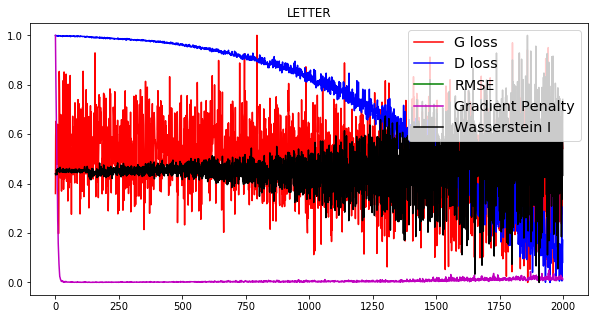

AUCH LETTER
Begin_draw_test torch.Size([4000, 33])
x_h (16000, 16)
data (20000, 17)
X_test (4000, 16)


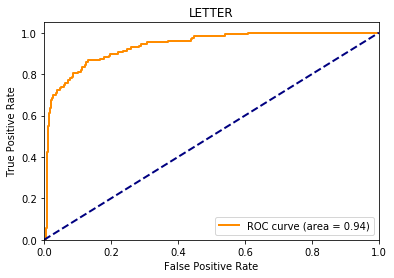

Begin_draw_test torch.Size([4000, 33])
x_h (16000, 16)
data (20000, 17)
X_test (4000, 16)


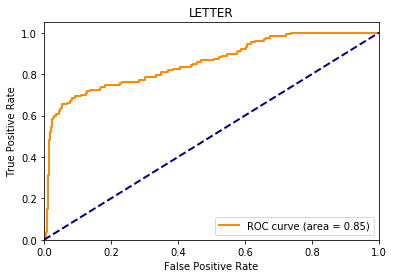

Begin_draw_test torch.Size([4000, 33])
x_h (16000, 16)
data (20000, 17)
X_test (4000, 16)


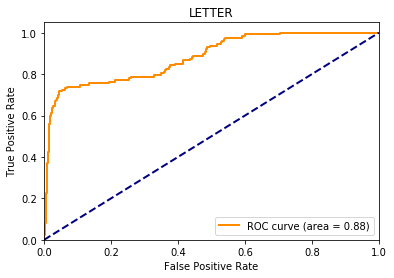

Begin_draw_test torch.Size([4000, 33])
x_h (16000, 16)
data (20000, 17)
X_test (4000, 16)


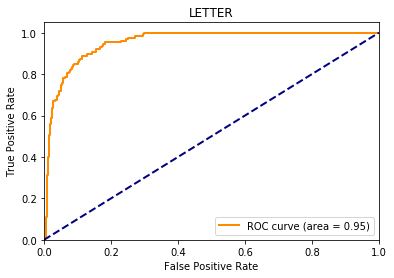

Begin_draw_test torch.Size([4000, 33])
x_h (16000, 16)
data (20000, 17)
X_test (4000, 16)


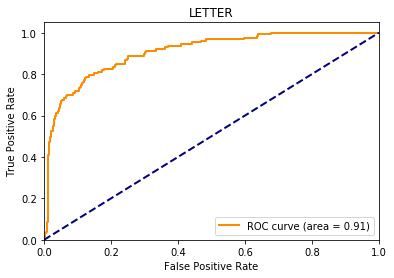

Begin_draw_test torch.Size([4000, 33])
x_h (16000, 16)
data (20000, 17)
X_test (4000, 16)


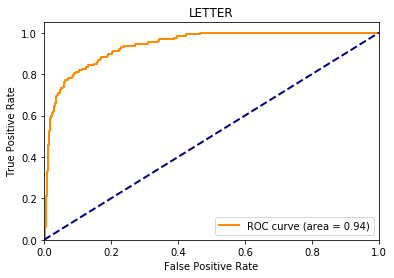

Begin_draw_test torch.Size([4000, 33])
x_h (16000, 16)
data (20000, 17)
X_test (4000, 16)


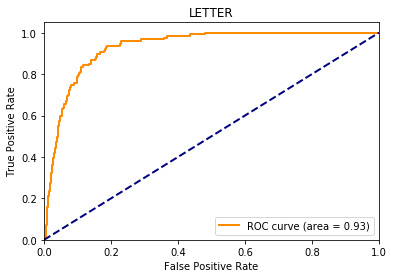

Begin_draw_test torch.Size([4000, 33])
x_h (16000, 16)
data (20000, 17)
X_test (4000, 16)


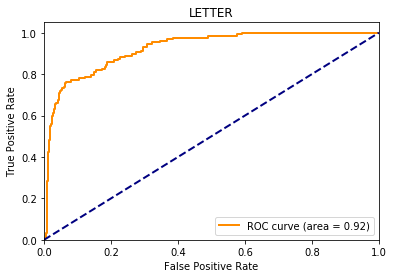

Begin_draw_test torch.Size([4000, 33])
x_h (16000, 16)
data (20000, 17)
X_test (4000, 16)


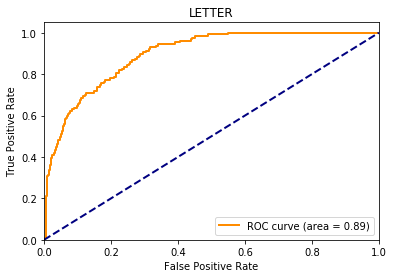

Begin_draw_test torch.Size([4000, 33])
x_h (16000, 16)
data (20000, 17)
X_test (4000, 16)


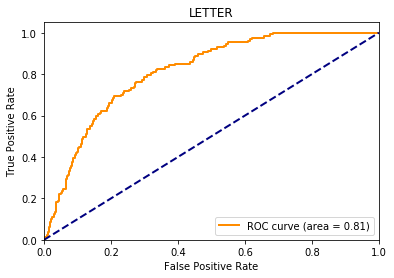

AUC_Mean 0.9032819580743732
STD 0.04155662367936176


In [12]:
num_epochs_l =2000
p_miss_l = 0.2
batch_l = 60
d_learning_rate_l = 0.001
g_learning_rate_l = 0.0001 
alpha_l = 0.1
LAMBDA_l = 10
hidden_size_l = 8

#Parameters
g_sgd_momentum_l = 0#.1#.3
d_sgd_momentum_l = 0#.9

# Only Continous
print('Dataset = Letter')
x_l = np.loadtxt('https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data',usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16), delimiter=',', dtype='float')
a = np.loadtxt('https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data', usecols=(0), delimiter=',', dtype='str')


a=[0 if x=='A' else x for x in a]
a=[1 if x=='B' else x for x in a]
a=[2 if x=='C' else x for x in a]
a=[3 if x=='D' else x for x in a]
a=[4 if x=='E' else x for x in a]
a=[5 if x=='F' else x for x in a]
a=[6 if x=='G' else x for x in a]
a=[7 if x=='H' else x for x in a]
a=[8 if x=='I' else x for x in a]
a=[9 if x=='J' else x for x in a]
a=[10 if x=='K' else x for x in a]
a=[11 if x=='L' else x for x in a]
a=[12 if x=='M' else x for x in a]
a=[13 if x=='N' else x for x in a]
a=[14 if x=='O' else x for x in a]
a=[15 if x=='P' else x for x in a]
a=[16 if x=='Q' else x for x in a]
a=[17 if x=='R' else x for x in a]
a=[18 if x=='S' else x for x in a]
a=[19 if x=='T' else x for x in a]
a=[20 if x=='U' else x for x in a]
a=[21 if x=='V' else x for x in a]
a=[22 if x=='W' else x for x in a]
a=[23 if x=='X' else x for x in a]
a=[24 if x=='Y' else x for x in a]
a=[25 if x=='Z' else x for x in a]

a= np.asarray(a)

y_l = np.asarray(a)
data_l= np.ones((20000,17))

data_l[:,0:16] = x_l
data_l[:,16] = y_l

run(num_epochs_l, p_miss_l, batch_l, d_learning_rate_l, g_learning_rate_l, alpha_l, LAMBDA_l, data_l,  hidden_size_l, g_sgd_momentum_l,d_sgd_momentum_l,'LETTER')

###Spam

In [0]:
num_epochs_s =8000
p_miss_s = 0.2
batch_s = 60
d_learning_rate_s = 0.00001
g_learning_rate_s = 0.001 
alpha_s = 0.1
LAMBDA_s = 10
hidden_size_s = 28
g_sgd_momentum_s = 0.3
d_sgd_momentum_s = 0.1


data_path = 'dataMaster/spambase/spambase.data'
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive
data_s = np.loadtxt(data_path,delimiter=',', dtype= float)
print('Dataset = SPAM')
run(num_epochs_s, p_miss_s, batch_s, d_learning_rate_s, g_learning_rate_s, alpha_s, LAMBDA_s, data_s,  hidden_size_s, g_sgd_momentum_s, d_sgd_momentum_s, 'SPAM')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
Dataset = SPAM
test, train torch.Size([3681, 115]) torch.Size([920, 115])
Epoch:  0
Epoch:  1000
Epoch:  2000
Epoch:  3000
Epoch:  4000


In [0]:

auroc_miss = [0.9320, .9270, 0.9226, 0.9029, 0.8788, 0.86847 ,0.8500, 0.7986,  0.7269 ]
gain_miss =[0.9305, 0.9151, 0.8893, 0.8531, 0.8115, 0.7840, 0.6991, 0.6630 , 0.5336 ]
miss = [10,20,30,40,50,60,70,80,90]

fig = plt.figure(figsize=(9,6))
plt.plot(miss, auroc_miss, color='green',  marker='o')
plt.plot(miss, gain_miss, marker = 'o')
plt.ylabel('AUROC')
plt.xlabel('Missing Rate (%)')
plt.legend(['WGAIN', 'GAIN'], loc='upper right')
plt.grid(True)
plt.show()

###Breast

In [0]:
# Varaibles Run
num_epochs_b =4000
p_miss_b = 0.2
batch_b = 20
d_learning_rate_b = 0.001
g_learning_rate_b = 0.1
alpha_b = 0.1
LAMBDA_b = 10
hidden_size_b = 15
g_sgd_momentum_b = 0#'0.4
d_sgd_momentum_b= 0#.9

#Only continous

#BREAST
from sklearn.datasets import load_breast_cancer
data_b = load_breast_cancer()
y = data_b.target
x = data_b.data
s = (569,31)
data_b = np.ones(s)
data_b[:,0:30] = x
data_b[:,30] = y

print('Dataset = Breast')
run(num_epochs_b, p_miss_b, batch_b, d_learning_rate_b, g_learning_rate_b, alpha_b, LAMBDA_b, data_b,  hidden_size_b, g_sgd_momentum_b, d_sgd_momentum_b,'BREAST')

### Credit

In [0]:
import pandas as pd
num_epochs_c =4000
p_miss_c  = 0.2
batch_c  = 60
d_learning_rate_c  = 0.001
g_learning_rate_c  = 0.001 
alpha_c  = 0.1
LAMBDA_c  = 10
hidden_size_c  = 11


data_path = 'dataMaster/Credit/defaultofcreditcardclients.xls'
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive

#No binary entries, but categorical and continous mixed, important for prediction
# Categorical: [1,2,3,5,6,7,8,9,10]
data_c = pd.read_excel(data_path, delimiter=',', type = 'float', skiprows= 1)
data_c = data_c.values
data_c = data_c.astype(float)
a = data_c[:,5:10]
a[a ==-1] = 9
a[a ==-2] = 10
a[a == 0] = 11

data_c[:,5:10] = a


print(data_c.shape[0])

print('Dataset = Credit')
run(num_epochs_c , p_miss_c , batch_c , d_learning_rate_c , g_learning_rate_c , alpha_c , LAMBDA_c , data_c,  hidden_size_c ,0,0, 'CREDIT')

'''

a[a ==-1] = 9
a[a ==-2] = 10
a[a == 0] = 11

data_c[:,5:10] = a

encoded_data = []
for i in range(1,11):
  if i != 4:
    print(i)
    x = data_c[:,i]
    enc = onehot(x)
    encoded_data.append(enc)

'''

In [0]:
rmse_miss = [0.1011, 0.1302, 0.1444, 0.1569, 0.1823, 0.2007 ,0.2056, 0.2138 ]
gain_miss = [0.1834, 0.1859, 0.1898, 0.1909, 0.1921, 0.2213 , 0.2490 , 0.2988 ]
miss = [10,20,30,40,50,60,70,80]

fig = plt.figure(figsize=(9,6))
plt.plot(miss, rmse_miss,  marker='o', color='green')
plt.plot(miss, gain_miss,  marker='o')
#plt.ylim([0.10, 0.34])
plt.yticks(np.arange(0.10, 0.36, 0.02))

plt.ylabel('RMSE')
plt.xlabel('Missing Rate (%)')
plt.legend(['WGAIN', 'GAIN'], loc='upper right')
plt.grid(True)
plt.show()